In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50,EfficientNetB0,MobileNetV2

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-08-28 11:49:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.3MB/s    in 4.4s    

2024-08-28 11:49:53 (14.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [14]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary'
        )

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
# training all the models now
models = [VGG16,InceptionV3,ResNet50,EfficientNetB0,MobileNetV2]

results = []
def train_models(models):
  '''
  This function trains all the models in the models list and the plot for the model wrt to the loss and accuracy and tabulates the details in the form of a dataframe
  here only the basic training of the model is done with only training the fcnn part of the models and not the entire model
  '''
  for model in models:
    base_model = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    name = model.__name__
    print(f"Model being trained is {name} \n")
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
      layer.trainable = False

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(train_generator,epochs=10,validation_data=validation_generator)

    #plotting the loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print("plots for model")
    fig,ax = plt.subplots(2,1,figsize=(10,10))
    ax[0].plot(acc,label='Training Accuracy')
    ax[0].plot(val_acc,label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc='lower right')
    ax[0].set_title('Training and Validation Accuracy')
    ax[1].plot(loss,label='Training Loss')
    ax[1].plot(val_loss,label='Validation Loss')
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(loc='upper right')
    ax[1].set_title('Training and Validation Loss')
    plt.show()

    #evaluating the model
    results.append({'model':name,'accuracy':history.history['accuracy'][-1],'val_accuracy':history.history['val_accuracy'][-1],'loss':history.history['loss'][-1],'val_loss':history.history['val_loss'][-1]})


Model being trained is VGG16 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.7239 - loss: 0.5330 - val_accuracy: 0.8760 - val_loss: 0.3008
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8733 - loss: 0.2878 - val_accuracy: 0.9160 - val_loss: 0.2378
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9039 - loss: 0.2416 - val_accuracy: 0.9240 - val_loss: 0.2112
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.9222 - loss: 0.1988 - val_accuracy: 0.9170 - val_loss: 0.2082
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9373 - loss: 0.1834 - val_accuracy: 0.9250 - val_loss: 0.1917
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9448 - loss: 0.1697 - val_accuracy: 0.9230 - val_loss: 0.1872
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9167 - loss: 0.1957 - val_accuracy: 0.9110 - val_loss: 0.2206
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/st

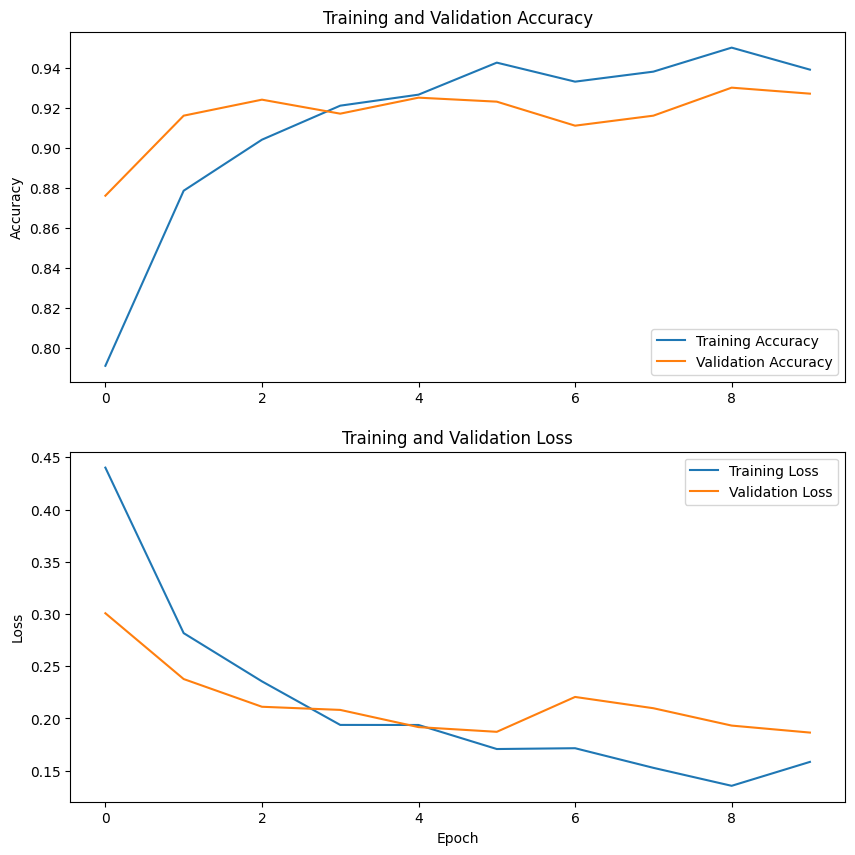

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model being trained is InceptionV3 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.9000 - loss: 0.3951 - val_accuracy: 0.9880 - val_loss: 0.0331
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - accuracy: 0.9897 - loss: 0.0378 - val_accuracy: 0.9840 - val_loss: 0.0538
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.9870 - val_loss: 0.0438
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9840 - val_loss: 0.0844
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9994 - loss: 0.0045 - val_accuracy: 0.9820 - val_loss: 0.0721
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9951 - loss: 0.0148 - val_accuracy: 0.9860 - val_loss: 0.0517
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9840 - val_loss: 0.0565
Epo

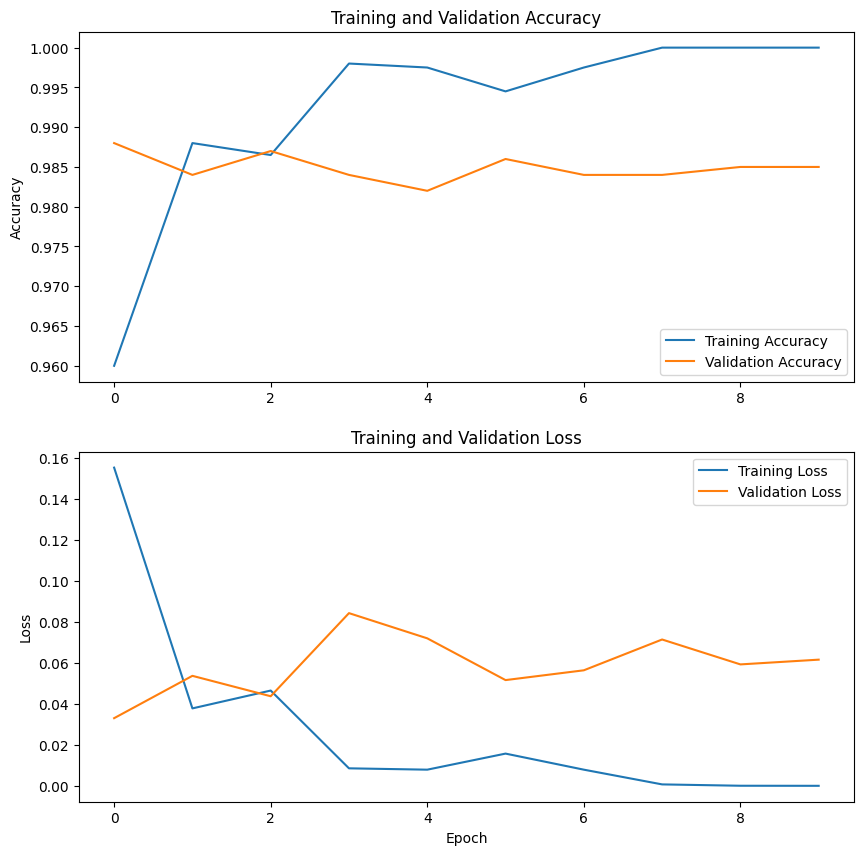

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Model being trained is ResNet50 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.5661 - loss: 0.7380 - val_accuracy: 0.5320 - val_loss: 0.6901
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.6058 - loss: 0.6655 - val_accuracy: 0.6120 - val_loss: 0.6413
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.6310 - loss: 0.6496 - val_accuracy: 0.6010 - val_loss: 0.6580
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.6024 - loss: 0.6690 - val_accuracy: 0.6390 - val_loss: 0.6368
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.6125 - loss: 0.6459 - val_accuracy: 0.6440 - val_loss: 0.6346
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6167 - loss: 0.6408 - val_accuracy: 0.6490 - val_loss: 0.6332
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.6505 - loss: 0.6282 - val_accuracy: 0.6510 - val_loss: 0.6348
Ep

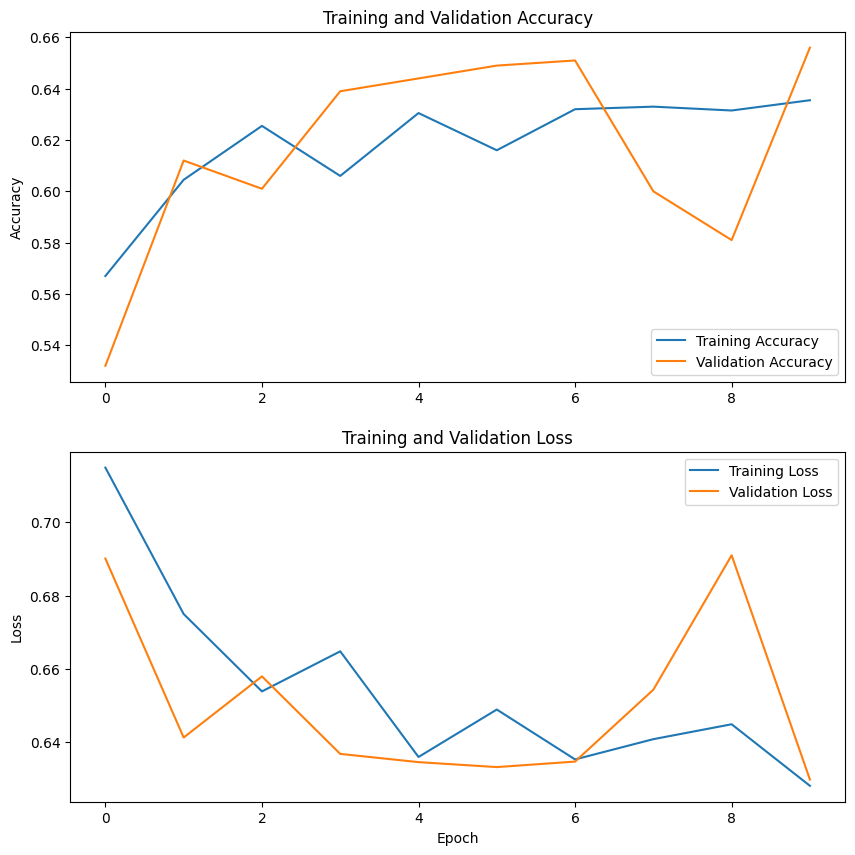

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model being trained is EfficientNetB0 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.4932 - loss: 0.7051 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.4943 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.5005 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.4800 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5008 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.5077 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4931 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932


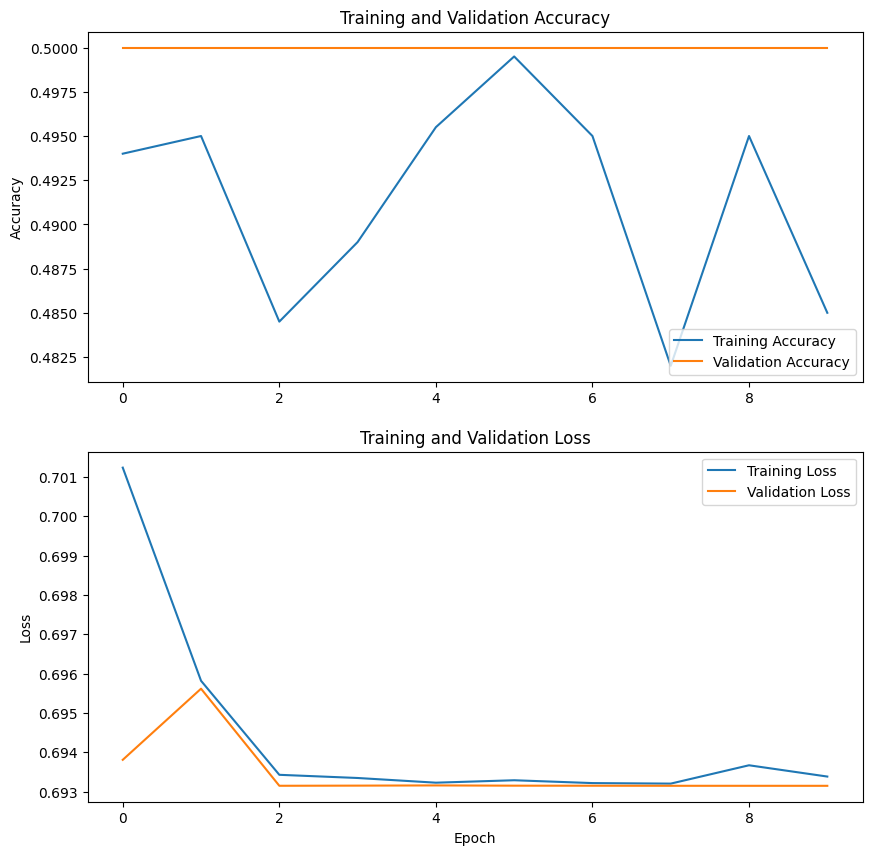

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model being trained is MobileNetV2 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9445 - loss: 0.1580 - val_accuracy: 0.9640 - val_loss: 0.1311
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9813 - loss: 0.0496 - val_accuracy: 0.9740 - val_loss: 0.1014
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9941 - loss: 0.0165 - val_accuracy: 0.9790 - val_loss: 0.1085
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9943 - loss: 0.0159 - val_accuracy: 0.9760 - val_loss: 0.1154
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.9961 - loss: 0.0102 - val_accuracy: 0.9750 - val_loss: 0.1088
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9750 - val_loss: 0.1151
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 3.6672e-04 - val_accuracy: 0.9760 - val_loss: 0.1163
Ep

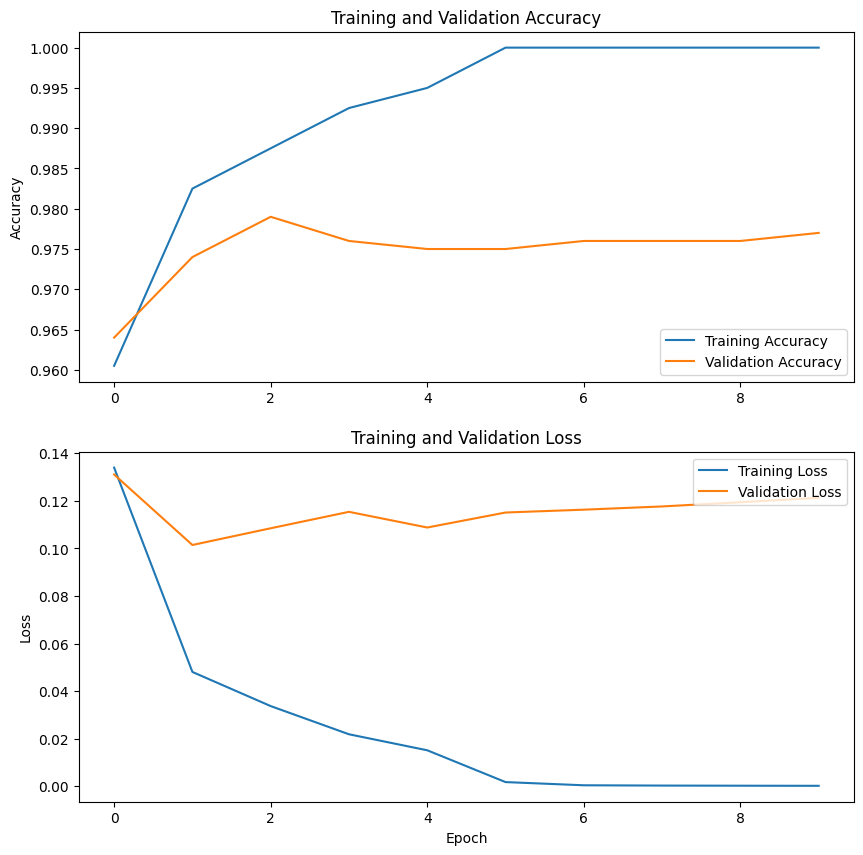

In [27]:
# calling the function
train_models(models)

In [28]:
# tabulating the results as a dataframe
df = pd.DataFrame(results)
df

,model,accuracy,val_accuracy,loss,val_loss
0,VGG16,0.9390,0.927,0.158454,0.186523
1,InceptionV3,1.0000,0.985,0.000091,0.061672
2,ResNet50,0.6355,0.656,0.628143,0.629849
3,EfficientNetB0,0.4850,0.500,0.693384,0.693148
4,MobileNetV2,1.0000,0.977,0.000170,0.121256
